Данный пример включает в себя ипользование библиотечной реализации метода CCM.

## **Тестирование метода CCM на 5-ти связанных рядах**

Рассмотрим пять временных рядов, порожденных одним и тем же физическим процессом, причем каждый последующий ряд включает в себя средние значения ансамблей предыдущих рядов.

Для примменения метода CCM к нашим рядам установим необходимый модуль и подключим библиотеки:

In [ ]:
!pip install skccm

  Created wheel for skccm: filename=skccm-0.2.dev0-cp37-none-any.whl size=12592 sha256=c81c27f78a526719e6b80e64d31a6ab8b8d0a730c59cf710bdcc830ae6550708
  Stored in directory: /root/.cache/pip/wheels/9f/23/e2/aa730525818a1dd3265f5c65edc6f1eab652e83efa14c44831
Successfully built skccm


In [ ]:
import skccm as ccm
from skccm import Embed
from skccm.utilities import train_test_split
import pandas as pd
import numpy as np
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
%matplotlib inline

Загрузим наш датасет из 5 временных рядов:

In [ ]:
initial = pd.read_csv('five_ranges.csv', sep=';', decimal=',', dtype = "float64")
df = initial.copy()
df.head()

,ряд 1,ряд 2,ряд 3,ряд 4,ряд 5,номер
0,-0.002679,-0.002769,-0.002742,-0.002980,-0.003144,1.0
1,-0.002409,-0.003191,-0.002713,-0.002760,-0.002940,2.0
2,-0.001811,-0.003250,-0.002729,-0.003000,-0.003078,3.0
3,-0.002067,-0.003441,-0.002328,-0.002648,-0.002756,4.0
4,-0.002324,-0.003435,-0.002519,-0.002806,-0.002802,5.0


Прежде чем применить метод CCM к данным, необходимо определить функции нахождения оптимальных параметров вложения (embedding) для дальнейшего построения лагового пространства (shadow manifold).

[Introduction to Taken's Embedding](https://www.kaggle.com/tigurius/introduction-to-taken-s-embedding/notebook)



### **Функция для определение оптимального значения задержки (delay)**

In [ ]:
# Считаем взаимуню информацию по заданной задержке

def calc_MutualInformation(signal, delay, nBins, verbose):
    I = 0
    xmax = np.max(signal)
    xmin = np.min(signal)
    
    signalDelay = signal[delay:len(signal)] # все точки, кроме первой задержки
    signalOriginal = signal[0:len(signal)-delay] # кроме последней задержки

    binsize = np.abs(xmax - xmin) / nBins
    
    # словари для ускорения процесса
    probInBin = {} # P_k
    # P_hk
    conditionBin = {}
    conditionDelayBin = {}
    
    for h in range(0, nBins):
        if h not in probInBin:
            conditionBin.update({h : (signalOriginal >= (xmin+h*binsize)) & (signalOriginal < (xmin+(h+1)*binsize))})
            probInBin.update({h : len(signalOriginal[conditionBin[h]]) / len(signalOriginal)})
        for k in range(0, nBins):
            if k not in probInBin:
                conditionBin.update({k : (signalOriginal >= (xmin+k*binsize)) & (signalOriginal < (xmin+(k+1)*binsize))})
                probInBin.update({k : len(signalOriginal[conditionBin[k]]) / len(signalOriginal)})
            if k not in conditionDelayBin:
                conditionDelayBin.update({k : (signalDelay >= (xmin+k*binsize)) & (signalDelay < (xmin+(k+1)*binsize))})
            Phk = len(signalOriginal[conditionBin[h] & conditionDelayBin[k]]) / len(signalOriginal)
            if Phk != 0 and probInBin[h] != 0 and probInBin[k] != 0:
                I -= Phk * math.log(Phk / (probInBin[h]*probInBin[k]))

    return I

### **Функция для определения оптимальной размерности**



In [ ]:
def computeFNN(signal, delay, dimension, R_thr=10):
    embeddedData = np.array([signal[0:len(signal)-delay*dimension]])
    for i in range(1, dimension):
      embeddedData = np.append(embeddedData, [signal[i*delay:len(signal) - delay*(dimension-i)]], axis=0)
    embSig = embeddedData.transpose()

    # т.к. 1й ближайший сосед - сама точка ряда, то берем 2го ближайшего соседа
    nbr = NearestNeighbors(n_neighbors=2).fit(embSig)

    # ищем k ближайших соседа точки
    distance, index = nbr.kneighbors(embSig) # возвращает расстояния до соседей каждой точки и индексы соседей

    epsilon = np.std(distance.flatten())
    distDiff = np.diff(distance) # разность между последовательными элементами

    nFNN = 0
    # ищем количество ложных ближайших соседей
    for i in range(0, len(signal)-delay*(dimension+1)):
        if distance[i,1] == 0: # во избежание деления на ноль
            R = abs(signal[i+dimension*delay] - signal[index[i,1]+dimension*delay]) / 0.01 # нормализуем расстояние
        else:
            R = abs(signal[i+dimension*delay] - signal[index[i,1]+dimension*delay-1]) / distance[i,1] # нормализуем расстояние
        if (0 < distDiff[i+1]) and (distDiff[i+1] < epsilon) and (R > R_thr):
            nFNN += 1

    return nFNN

### **Определение оптимальных значений задержки и размерности**

In [ ]:
def find_lag_opt(nDelay, signalX, signalY, nBins, verbose=0):
    delay_vector = np.arange(1, nDelay + 1)
    info_vectorX = []
    info_vectorY = []
    
    for i in delay_vector:
        info_vectorX = np.append(info_vectorX, [calc_MutualInformation(signalX, i, nBins, verbose=verbose)])
        info_vectorY = np.append(info_vectorY, [calc_MutualInformation(signalY, i, nBins, verbose=verbose)])
     
    idx_minI_X = np.argmin(info_vectorX)
    idx_minI_Y = np.argmin(info_vectorY)
    
    lag_optX = delay_vector[idx_minI_X]
    lag_optY = delay_vector[idx_minI_Y]
    
    return lag_optX, lag_optY

In [ ]:
def find_dim_opt(nDim, signalX, signalY, tauX, tauY):
    dim_range = np.arange(1, nDim+1)
    num_FNN_X = []
    num_FNN_Y = []
    
    for i in dim_range:
        num_FNN_X = np.append(num_FNN_X, [computeFNN(signalX, tauX, i)])
        num_FNN_Y = np.append(num_FNN_Y, [computeFNN(signalY, tauY, i)])
        
    idx_minDim_X = np.argmin(num_FNN_X)
    idx_minDim_Y = np.argmin(num_FNN_Y)
    
    dim_optX = dim_range[idx_minDim_X]
    dim_optY = dim_range[idx_minDim_Y]
    
    return dim_optX, dim_optY

### **Применение метода CCM**

Будем применять метод CCM к рядам попарно, ища зависимость всех рядов с пятым. Гипотеза в том, что CCM должен показать рост зависимости при увеличении индекса сравниваемых рядов: 1-5, 2-5, ..., 5-5.

[Реализация метода CCM в модуле skccm](https://buildmedia.readthedocs.org/media/pdf/skccm/latest/skccm.pdf).

 Ряды 1-5:


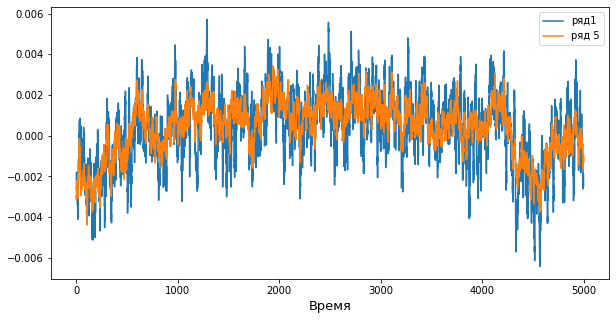

Оптимальное значение задержки для Mx и My:  1
Оптимальное значение размерности эмбэддинга для Mx и My одинаковы и равны: 5

Коэфициенты корреляции CCM рядов 1-5:
Cxy = 0.635132254077892
Cyx = 0.6604256339330182




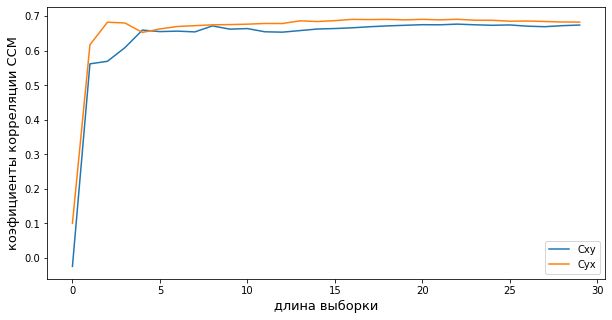

 Ряды 2-5:


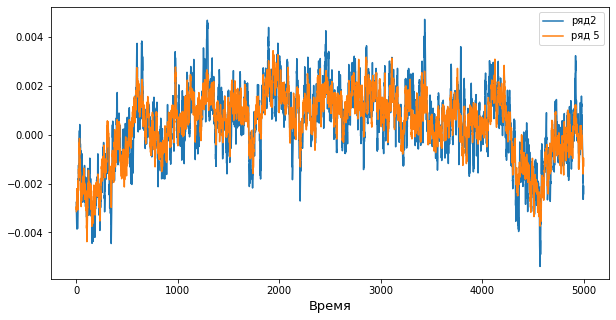

Оптимальное значение задержки для Mx и My:  1
Оптимальное значение размерности эмбэддинга для Mx и My одинаковы и равны: 5

Коэфициенты корреляции CCM рядов 2-5:
Cxy = 0.7856660214954568
Cyx = 0.809877569277475




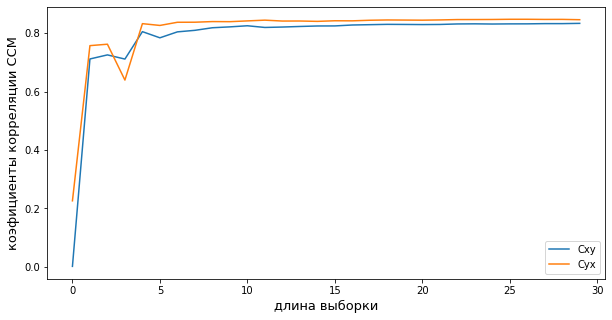

 Ряды 3-5:


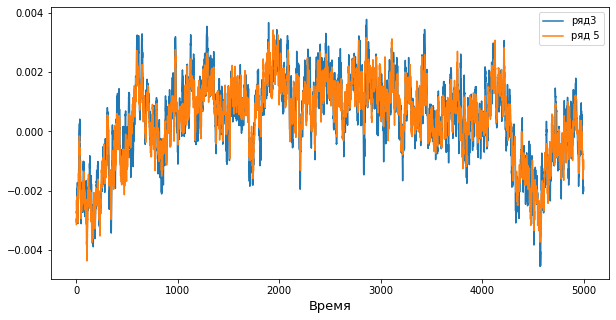

Оптимальное значение задержки для Mx и My:  1
Оптимальное значение размерности эмбэддинга для Mx и My одинаковы и равны: 5

Коэфициенты корреляции CCM рядов 3-5:
Cxy = 0.85471475414217
Cyx = 0.8787019522493954




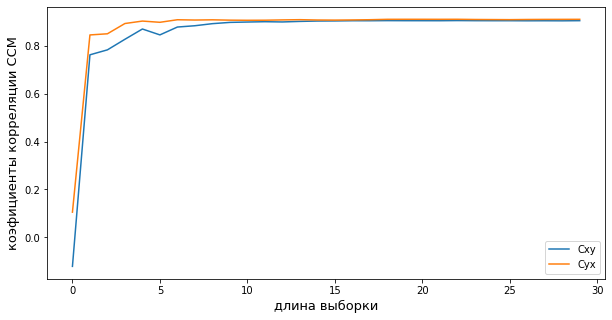

 Ряды 4-5:


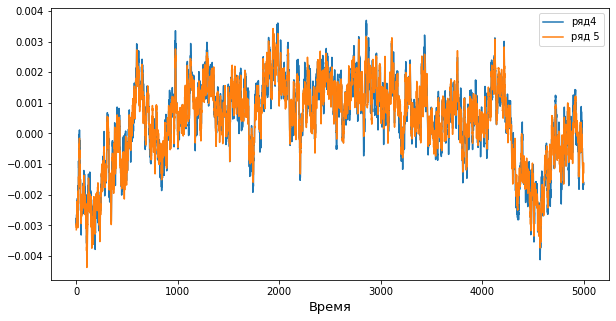

Оптимальное значение задержки для Mx и My:  1
Оптимальное значение размерности эмбэддинга для Mx и My одинаковы и равны: 5

Коэфициенты корреляции CCM рядов 4-5:
Cxy = 0.9088270616251438
Cyx = 0.9185246661964893




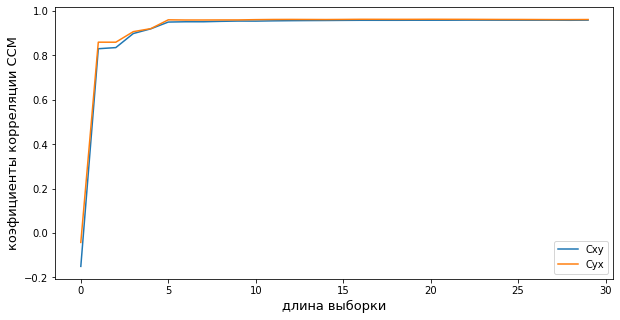

 Ряды 5-5:


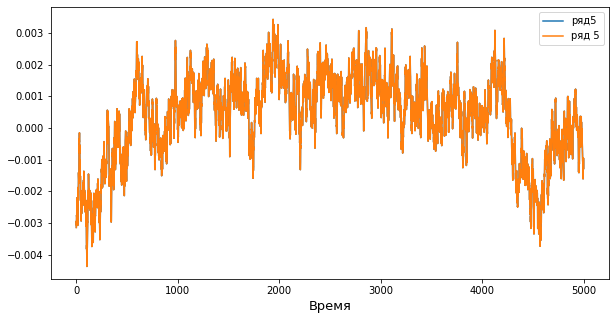

Оптимальное значение задержки для Mx и My:  1
Оптимальное значение размерности эмбэддинга для Mx и My одинаковы и равны: 5

Коэфициенты корреляции CCM рядов 5-5:
Cxy = 0.9444598996709518
Cyx = 0.9444598996709518




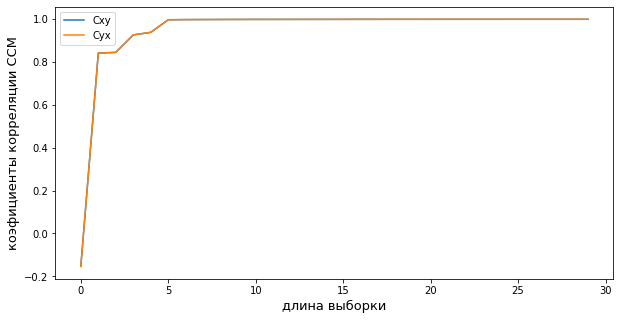

In [ ]:
# Начальные параметры
nDelay = 50 # максимально возможная задержка
nBins = 100 # количество сегментов данных
nDim = 50 # максимально возможная размерность пространства

for i in range(1, 6): # проходимся по 5-ти рядам
  print("\033[1m Ряды {}-5:".format(i))

  x1 = np.asarray(df['ряд '+ str(i)][:5000]) # для ускорения вычислений берем часть датасета
  x2 = np.asarray(df['ряд 5'][:5000])

  # строим на одном графике 2 временных ряда
  plt.figure(figsize=(10,5))
  plt.plot(x1)
  plt.plot(x2)
  plt.xlabel('Время', fontsize = 13)
  plt.legend(['ряд' + str(i), 'ряд 5'], loc = 'best')
  plt.show()

  # ищем оптимальные значения задержки
  lagX, lagY = find_lag_opt(nDelay, x1, x2, nBins)
  lag = lagX
  print('Оптимальное значение задержки для Mx и My: ', lag)

  # ищем оптимальные значения размерностей эмбэддингов
  dim_optX, dim_optY = find_dim_opt(nDim, x1, x2, lagX, lagY)

  # проверка, что два лаговых пространства (shadow manifolds) имеют одинаковую размерность
  if dim_optX != dim_optY:
    embed = max(dim_optX, dim_optY)
    print('Оптимальное значение размерности эмбэддинга для Mx и My: {}\n'.format(embed))
  else:
    embed = dim_optX
    print('Оптимальное значение размерности эмбэддинга для Mx и My одинаковы и равны: {}\n'.format(embed))

  if lag*embed > len(x1) or lag*embed > len(x2):
    raise NameError('Ошибка! Задержка*размерность превышает длину временного ряда. Измените параметры!')

  # строим эмбэддинги временных рядов по заданным параметрам
  e1 = ccm.Embed(x1)
  e2 = ccm.Embed(x2)
  # переводим векторы из одномерного временного ряда в m-мерное пространство (т.е. строим лаговое пространство)
  X1 = e1.embed_vectors_1d(lag,embed)
  X2 = e2.embed_vectors_1d(lag,embed)

  # разбиваем ряды на обучающую и тестовую выборки
  x1_train, x1_test, x2_train, x2_test = train_test_split(X1, X2, percent=.75)
  CCM = ccm.CCM() # инициализируем класс CCM
  # задаем длину выборки: берем 30 точек от embed+1 до длины x1tr
  lib_lens = np.arange(embed+1, len(x1_train), len(x1_train)/30, dtype='int')
  # обучаем CCM и считаем коэфициенты корреляции
  CCM.fit(x1_train, x2_train)
  x1p, x2p = CCM.predict(x1_test, x2_test, lib_lengths=lib_lens)
  sc1,sc2 = CCM.score()

  # выводим среднее по коэфициентам корреляции CCM
  print("Коэфициенты корреляции CCM рядов {}-5:\nCxy = {}\nCyx = {}\n\n".format(i, np.mean(sc1),np.mean(sc2)))

  plt.figure(figsize=(10,5))
  plt.plot(sc1)
  plt.plot(sc2)
  plt.xlabel('длина выборки', fontsize = 13)
  plt.ylabel('коэфициенты корреляции CCM', fontsize = 13)
  plt.legend(['Cxy', 'Cyx'], loc = 'best')
  plt.show()

Тем самым подтверждается гипотеза о том, что CCM должен показать рост зависимости при увеличении индекса сравниваемых рядов (1-5, 2-5, ..., 5-5).

Также для всех пар рядов $C_{YX} > C_{XY}$, следовательно, динамика 5-го ряда лучше описывается рядами более низких индексов, чем наоборот. Т.к ряд 5 содержит информацию о динамиках предыдущих рядов рядов, то самым меньшему индексу легче "говорить о динамике" 5-го, чем наоборот.